In [1]:
#data analysis of the predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
import datetime
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
%matplotlib inline

In [3]:
alldata_processed =\
    pd.read_csv("./data/processed/alldata_processed_with_dev_residual.csv" )
alldata_processed['videoid'] = alldata_processed['videoid'].apply(lambda x: int(x))
#alldata_processed['Event_Date'] = pd.to_datetime(alldata_processed['Event_Date'],format='%Y-%m-%d')

In [4]:
#RR AUCROC
df = alldata_processed.copy()

In [7]:
predictions = pd.read_csv("./data/predictions/rr_SEMLS_dev_residual_predictions.csv",dtype={'videoid':int})[['videoid','side','SEMLS_dev_residual_pred']]
df = df.merge(right=predictions,on=['videoid','side'],how='left')
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         #'SEMLS_dev_residual_pred',#"isPostSurgGaitVisit",
         "const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS_rr'] = lm.predict(X)

Optimization terminated successfully.
         Current function value: 0.434308
         Iterations 7


In [9]:
#RF AUCROC
predictions = pd.read_csv("./data/predictions/rf_SEMLS_dev_residual_predictions.csv",dtype={'videoid':int})[['videoid','side','SEMLS_dev_residual_pred']]
df = df.drop('SEMLS_dev_residual_pred',axis=1)
df = df.merge(right=predictions,on=['videoid','side'],how='left')
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         #'SEMLS_dev_residual_pred',"isPostSurgGaitVisit",
         "const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS_rf'] = lm.predict(X)

Optimization terminated successfully.
         Current function value: 0.434308
         Iterations 7


In [16]:
#CNN AUCROC
predictions = pd.read_csv("./data/predictions/cnn_GDI_predictions_best_epoch.csv",dtype={'videoid':int})[['videoid']]#,'side','SEMLS_dev_residual_pred_corrected']]
#df = df.drop('SEMLS_dev_residual_pred',axis=1)
df = df.merge(right=predictions,on=['videoid'],how='left')

Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         #'SEMLS_dev_residual_pred_corrected',"isPostSurgGaitVisit",
         "const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS_CNN'] = lm.predict(X)


Optimization terminated successfully.
         Current function value: 0.434308
         Iterations 7


In [18]:
#CNN AUCROC
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         'GDI',#"isPostSurgGaitVisit",
         "const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS_GDI'] = lm.predict(X)


Optimization terminated successfully.
         Current function value: 0.405942
         Iterations 7


In [23]:
fpr_cnn, tpr_cnn, _ = roc_curve(df[df['dataset'] == 'test']['SEMLS'],
          df[df['dataset'] == 'test']['predicted_SEMLS_CNN'])

fpr_rf, tpr_rf, _ = roc_curve(df[df['dataset'] == 'test']['SEMLS'],
          df[df['dataset'] == 'test']['predicted_SEMLS_rf'])

fpr_rr, tpr_rr, _ = roc_curve(df[df['dataset'] == 'test']['SEMLS'],
          df[df['dataset'] == 'test']['predicted_SEMLS_rr'])

fpr_gdi, tpr_gdi, _ = roc_curve(df[df['dataset'] == 'test']['SEMLS'],
          df[df['dataset'] == 'test']['predicted_SEMLS_GDI'])

[0.         0.00518135 0.00518135 0.00777202 0.01295337 0.01295337
 0.02849741 0.02849741 0.05440415 0.05699482 0.06735751 0.06735751
 0.09326425 0.09326425 0.11398964 0.11398964 0.19170984 0.19170984
 0.19689119 0.19689119 0.24352332 0.24611399 0.27202073 0.2746114
 0.28497409 0.28497409 0.29015544 0.29274611 0.29792746 0.30051813
 0.30569948 0.30569948 0.32642487 0.32901554 0.32901554 0.33160622
 0.33160622 0.34196891 0.34196891 0.34715026 0.34715026 0.3626943
 0.3626943  0.37823834 0.38082902 0.38601036 0.38601036 0.4015544
 0.4015544  0.41709845 0.41968912 0.42487047 0.42487047 0.4611399
 0.46373057 0.48445596 0.48704663 0.51295337 0.51295337 0.51554404
 0.57253886 0.57253886 0.59326425 0.59326425 0.60362694 0.60362694
 0.63471503 0.63471503 0.64507772 0.64507772 0.64766839 0.67357513
 0.67357513 0.67875648 0.67875648 0.68393782 0.6865285  0.7642487
 0.76683938 0.81865285 0.81865285 0.8238342  0.8238342  0.86010363
 0.8626943  0.94559585 0.94818653 1.        ]


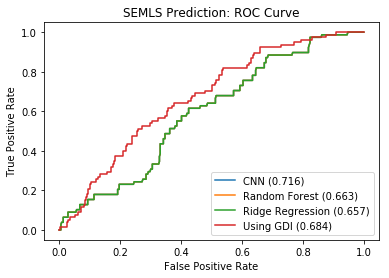

In [51]:
plt.clf()
plt.plot(fpr_cnn,tpr_cnn, label="CNN (0.716)")
plt.plot(fpr_rf,tpr_rf, label="Random Forest (0.663)")
plt.plot(fpr_rr,tpr_rr, label="Ridge Regression (0.657)")
plt.plot(fpr_gdi,tpr_gdi, label="Using GDI (0.684)")
plt.legend(loc=4)
plt.title("SEMLS Prediction: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("figures/semls_performance.png",dpi=600)

In [47]:
print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS_CNN']),"CNN: test ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS_rf']),"RF: test ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS_rr']),"RR: test ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS_GDI']),"Using GDI: test ROC")


0.5914707054603429 CNN: test ROC
0.5914707054603429 RF: test ROC
0.5914707054603429 RR: test ROC
0.6701208981001727 Using GDI: test ROC
